In [1]:
%load_ext autoreload
%load_ext blackcellmagic
%autoreload 2

import os as os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from matplotlib.gridspec import GridSpec
%matplotlib inline

import parmed as pmd
import pytraj as pt

from smirnovert.utils import *

from adjustText import adjust_text

Using `git` to find current version`.


In [2]:
def prepare_plot():
    """
    Set up general plot aesthetics to be used for including figures in a manuscript or talk.
    These defaults are possibly too large for interactive use.
    This function should be called before `paper_plot`.
    """
    sns.set()
    # Increase font size and linewidth
    sns.set_context("talk")
    sns.set_style("whitegrid")
    # Use LaTeX, setup to use Helvetica. This can be safely commented to make
    # the installation footprint of running this code smaller -- for example,
    # in Docker.
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [
        r'\usepackage{amsmath}',
        r'\usepackage{helvet}',
        r'\usepackage[EULERGREEK]{sansmath}',
        r'\sansmath',
        r'\renewcommand{\familydefault}{\sfdefault}',
        r'\usepackage[T1]{fontenc}',
        r'\usepackage{graphicx}'
    ]

def paper_plot(fig, adjustment=0, scientific=False, save=False, filename=None,
               raster=False, label_pad=True):
    """
    Take a prepared figure and make additional adjustments for inclusion in manuscript:
    mostly tick thickness, length, and label padding, and include only the left and the bottom
    axis spines. It would be nice to force the axes to end on a major tick, but I haven't
    figured out how to do that yet.
    """
    for ax in fig.axes:
        # Increase padding
        ax.tick_params(which='major', direction='out', length=10, pad=10)
        ax.tick_params(which='minor', direction='out', length=5)
        # If plotting with pi, increase the x tick size specifically
        # ax.tick_params(axis='x', labelsize=40, pad=-10)
        # Increase tick thickness
        ax.xaxis.set_tick_params(width=2)
        ax.yaxis.set_tick_params(width=2)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if label_pad:
            # Increase padding
            ax.xaxis.labelpad = 15
            ax.yaxis.labelpad = 15
        # Make the background color white
        facecolor = 'white'
        if facecolor is False:
            facecolor = fig.get_facecolor()
        alpha = 1
        color_with_alpha = colorConverter.to_rgba(facecolor, alpha)
        fig.patch.set_facecolor(color_with_alpha)
        # Stick the scientific notation into the axis label, instead of the
        # default position which in the corner, which really makes no sense.
        if ax.xaxis.get_scale() == 'linear':
            if scientific:
                pretty_label(ax)
            ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
            ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        elif ax.xaxis.get_scale() == 'log':
            pass
        # For scatter plots, where points get cut off
        if adjustment != 0:
            x0, x1, y0, y1 = ax.axis()
            ax.xaxis((x0 - adjustment,
                      x1 + adjustment,
                      y0,
                      y1
                     ))
        # Make axes thicker
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
    if save:
        plt.savefig(filename + '.png', dpi=300, bbox_inches='tight')
        plt.savefig(filename + '.svg', dpi=300, bbox_inches='tight')


In [3]:
prepare_plot()

In [4]:
original = pmd.load_file(
    "tests/a-bam-p/confirm-original/a000/full.hmr.topo",
    "tests/a-bam-p/confirm-original/a000/full.crds",
    structure=True,
)

smirnoff = pmd.load_file(
    "tests/a-bam-p/smirnoff/a000/smirnoff.prmtop",
    "tests/a-bam-p/smirnoff/a000/smirnoff.inpcrd",
    structure=True,
)

In [5]:
original.strip(":Na+,:Cl-,:WAT,@Pb")
smirnoff.strip(":Na+,:Cl-,:WAT,@Pb")

We know the *charges* will be the same here. So let's keep track of the dihedrals by charge.

In [6]:
original_df = pd.DataFrame()
for dihedral in original.dihedrals:
    original_df = original_df.append(pd.DataFrame({"atom1" : np.round(dihedral.atom1._charge, 2),
                                                   "atom2" : np.round(dihedral.atom2._charge, 2),
                                                   "atom3" : np.round(dihedral.atom3._charge, 2),
                                                   "atom4" : np.round(dihedral.atom4._charge, 2),
                                                   "phase" : np.round(dihedral.type.phase, 2),
                                                   "per" : int(dihedral.type.per),
                                                   "phi" : dihedral.type.phi_k
                                                  }, index=[0]), ignore_index = True
    )

In [7]:
original_df = pd.DataFrame()
for dihedral in original.dihedrals:
    original_df = original_df.append(pd.DataFrame({"atom1" : dihedral.atom1.name,
                                                   "atom2" : dihedral.atom2.name,
                                                   "atom3" : dihedral.atom3.name,
                                                   "atom4" : dihedral.atom4.name,
                                                   "phase" : np.round(dihedral.type.phase, 2),
                                                   "per" : int(dihedral.type.per),
                                                   "phi" : dihedral.type.phi_k
                                                  }, index=[0]), ignore_index = True
    )

In [8]:
original_df.drop_duplicates(inplace=True)

In [9]:
smirnoff_df = pd.DataFrame()
for dihedral in smirnoff.dihedrals:
    smirnoff_df = smirnoff_df.append(pd.DataFrame({"atom1" : dihedral.atom1.name,
                                                   "atom2" : dihedral.atom2.name,
                                                   "atom3" : dihedral.atom3.name,
                                                   "atom4" : dihedral.atom4.name,
                                                   "phase" : np.around(dihedral.type.phase, 2),
                                                   "per" : int(dihedral.type.per),
                                                   "phi" : dihedral.type.phi_k
                                                  }, index=[0]), ignore_index = True
    )

In [10]:
smirnoff_df.drop_duplicates(inplace=True)

In [11]:
print(f"There are {len(original_df)} dihedrals applied from GAFF and {len(smirnoff_df)} dihedrals applied with SMIRNOFF99Frosst.")

There are 160 dihedrals applied from GAFF and 169 dihedrals applied with SMIRNOFF99Frosst.


In [12]:
# smirnoff_df.to_csv("smirnoff_dihedrals.csv")

In [13]:
merged = original_df.merge(smirnoff_df, on=["atom1", "atom2", "atom3", "atom4", "phase", "per"])

In [14]:
# merged.to_csv("dihedrals.csv")

In [15]:
merged["difference"] = merged["phi_x"] - merged["phi_y"]

71

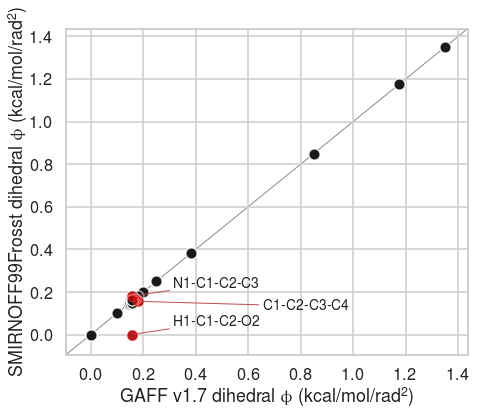

In [54]:
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

ax.scatter(
    merged["phi_x"],
    merged["phi_y"],
    s=120,
    c = "k",
    alpha=0.8,
    edgecolor="w",
    lw=1,
)

texts = []
for index, row in merged.iterrows():
    if abs(row["difference"]) > 0.01:
        ax.scatter(
            row["phi_x"],
            row["phi_y"],
            s=120,
            c = "red",
            alpha=0.6,
            edgecolor="w",
            lw=0.2,
        )
        texts.append(plt.text(row["phi_x"], row["phi_y"],
                             f"{row['atom1']}-{row['atom2']}-{row['atom3']}-{row['atom4']}",
                             fontsize=14,
                             ))



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k-", lw=1, alpha=0.5, zorder=0)
# ax.set_aspect("equal")
ax.grid(zorder=-1)
ax.set_xlabel("GAFF v1.7 dihedral $\phi$ (kcal/mol/rad$^2$)")
ax.set_ylabel("SMIRNOFF99Frosst dihedral $\phi$ (kcal/mol/rad$^2$)")
ax.set_xlim(lims)
ax.set_ylim(lims)
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='r', lw=1), expand_points=(2,2))
# paper_plot(fig)

In [56]:
merged[(merged["atom1"] == "H1") & (merged["atom2"] == "C1") & (merged["atom3"] == "C2") & (merged["atom4"] == "O2")]

,atom1,atom2,atom3,atom4,phase,per,phi_x,phi_y,difference
119,H1,C1,C2,O2,0.0,3,0.155556,0.0,0.155556


In [57]:
original_df[(original_df["atom1"] == "H1") & (original_df["atom2"] == "C1") & (original_df["atom3"] == "C2") & (original_df["atom4"] == "O2")]

,atom1,atom2,atom3,atom4,phase,per,phi
346,H1,C1,C2,O2,0.0,3,0.155556


In [58]:
smirnoff_df[(smirnoff_df["atom1"] == "H1") & (smirnoff_df["atom2"] == "C1") & (smirnoff_df["atom3"] == "C2") & (smirnoff_df["atom4"] == "O2")]

,atom1,atom2,atom3,atom4,phase,per,phi
296,H1,C1,C2,O2,0.0,3,0.00
297,H1,C1,C2,O2,0.0,1,0.25


In [59]:
merged2 = smirnoff_df.merge(original_df, on=["atom1", "atom2", "atom3", "atom4", "phase", "per"], indicator=True, how="left")

In [60]:
merged2[merged2["_merge"] == "left_only"]

,atom1,atom2,atom3,atom4,phase,per,phi_x,phi_y,_merge
3,O5,C1,C2,O2,0.0,3,0.144,NaN,left_only
4,O5,C1,C2,O2,0.0,2,1.175,NaN,left_only
5,O5,C1,C2,C3,0.0,3,0.156,NaN,left_only
41,N1,C1,C2,C3,180.0,2,0.250,NaN,left_only
42,N1,C1,C2,C3,180.0,1,0.200,NaN,left_only
72,O5,C1,C2,H2,0.0,3,0.000,NaN,left_only
73,O5,C1,C2,H2,0.0,1,0.250,NaN,left_only
75,H1,C1,C2,O2,0.0,1,0.250,NaN,left_only


In [61]:
merged2[merged2["_merge"] == "left_only"].to_csv("missing-dihedrals.csv")

86

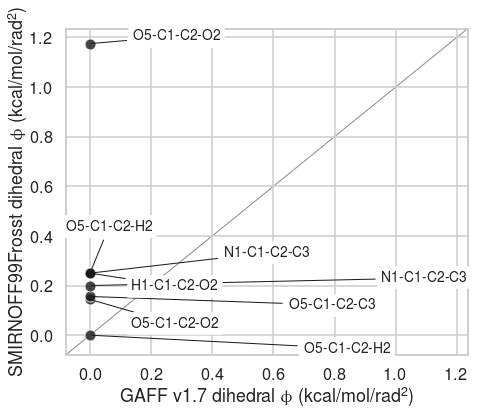

In [77]:
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

texts = []
for index, row in merged2[merged2["_merge"] == "left_only"].iterrows():

    ax.scatter(
        0, 
        row["phi_x"],
        s=120,
        c = "k",
        alpha=0.8,
        edgecolor="w",
        lw=1,
    )
    
    texts.append(plt.text(0, row["phi_x"],
                         f"{row['atom1']}-{row['atom2']}-{row['atom3']}-{row['atom4']}",
                         fontsize=14, backgroundcolor="w",
                         ))



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k-", lw=1, alpha=0.5, zorder=0)
# ax.set_aspect("equal")
ax.grid(zorder=-1)
ax.set_xlabel("GAFF v1.7 dihedral $\phi$ (kcal/mol/rad$^2$)")
ax.set_ylabel("SMIRNOFF99Frosst dihedral $\phi$ (kcal/mol/rad$^2$)")
ax.set_xlim(lims)
ax.set_ylim(lims)
# paper_plot(fig)
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=1), expand_points=(2,2), expand_text=(2,2))

In [78]:
original.bond_types

TrackedList([
	<BondType; k=369.600, req=0.974>
	<BondType; k=335.900, req=1.093>
	<BondType; k=314.100, req=1.426>
	<BondType; k=301.500, req=1.439>
	<BondType; k=303.100, req=1.535>
	<BondType; k=326.400, req=1.100>
	<BondType; k=337.300, req=1.092>
	<BondType; k=338.700, req=1.091>
	<BondType; k=369.000, req=1.033>
	<BondType; k=293.600, req=1.499>
	<BondType; k=553.000, req=0.957>
	<BondType; k=553.000, req=1.514>
])

In [79]:
smirnoff.bond_types

TrackedList([
	<BondType; k=310.000, req=1.526>
	<BondType; k=367.000, req=1.470>
	<BondType; k=320.000, req=1.370>
	<BondType; k=320.000, req=1.410>
	<BondType; k=340.000, req=1.090>
	<BondType; k=434.000, req=1.010>
	<BondType; k=553.000, req=0.960>
	<BondType; k=553.000, req=1.514>
	<BondType; k=553.000, req=0.957>
])

In [84]:
for smirnoff_atom, gaff_atom in zip(original.atoms, smirnoff.atoms):
    print(smirnoff_atom.name, gaff_atom.name)

Pb C1
Pb H1
Pb O1
C1 C2
H1 H2
O1 O2
C2 HO2
H2 C3
O2 H3
HO2 O3
C3 HO3
H3 C4
O3 H4
HO3 C5
C4 H5
H4 O5
C5 C6
H5 H61
O5 H62
C6 O6
H61 HO6
H62 C1
O6 H1
HO6 O1
C1 C2
H1 H2
O1 O2
C2 HO2
H2 C3
O2 H3
HO2 O3
C3 HO3
H3 C4
O3 H4
HO3 C5
C4 H5
H4 O5
C5 C6
H5 H61
O5 H62
C6 O6
H61 HO6
H62 C1
O6 H1
HO6 O1
C1 C2
H1 H2
O1 O2
C2 HO2
H2 C3
O2 H3
HO2 O3
C3 HO3
H3 C4
O3 H4
HO3 C5
C4 H5
H4 O5
C5 C6
H5 H61
O5 H62
C6 O6
H61 HO6
H62 C1
O6 H1
HO6 O1
C1 C2
H1 H2
O1 O2
C2 HO2
H2 C3
O2 H3
HO2 O3
C3 HO3
H3 C4
O3 H4
HO3 C5
C4 H5
H4 O5
C5 C6
H5 H61
O5 H62
C6 O6
H61 HO6
H62 C1
O6 H1
HO6 O1
C1 C2
H1 H2
O1 O2
C2 HO2
H2 C3
O2 H3
HO2 O3
C3 HO3
H3 C4
O3 H4
HO3 C5
C4 H5
H4 O5
C5 C6
H5 H61
O5 H62
C6 O6
H61 HO6
H62 C1
O6 H1
HO6 O1
C1 C2
H1 H2
O1 O2
C2 HO2
H2 C3
O2 H3
HO2 O3
C3 HO3
H3 C4
O3 H4
HO3 C5
C4 H5
H4 O5
C5 C6
H5 H61
O5 H62
C6 O6
H61 HO6
H62 N1
O6 H1
HO6 H2
N1 HN11
H1 C1
H2 H3
HN11 H4
C1 C2
H3 H5
H4 H6
C2 C3
H5 H7
H6 H8
C3 C4
H7 H9
H8 H10
C4 H11
H9 Pb
H10 Pb
H11 Pb
O O
H1 H1
H2 H2
O O
H1 H1
H2 H2
O O
H1 H1
H2 H2
O O
H1 H

In [85]:
for original_atom in original.atoms:
    np.where(original_atom.name == smirnoff.atoms.names)

AttributeError: 'AtomList' object has no attribute 'names'